In [52]:
import pandas as pd 
import re
from unidecode import unidecode



In [75]:
wikipedia = open(r'C:\Users\SBK\Documents\NLP\HW3\wiki.tr.txt')
lines = wikipedia.readlines()
dt = pd.DataFrame()

In [68]:
def preprocessing(txt):
    txt = txt.lower()
    txt = unidecode(txt)
    txt = txt.replace('\n','')
    pattern_de = re.compile(r'\w+de\b')
    pattern_da = re.compile(r'\w+da\b')
    pattern_ki = re.compile(r'\w+ki\b')

    matches_de = pattern_de.findall(txt)
    matches_da = pattern_da.findall(txt)
    matches_ki = pattern_ki.findall(txt)
    
    pattern_space_de =  re.compile(r'\w+ de\b')
    pattern_space_da =  re.compile(r'\w+ da\b')
    pattern_space_ki =  re.compile(r'\w+ ki\b')

    matches_space_de = pattern_space_de.findall(txt)
    matches_space_da = pattern_space_da.findall(txt)
    matches_space_ki = pattern_space_ki.findall(txt)
    if len(matches_de)>=0 or len(matches_da)>=0 or len(matches_ki)>=0:
        label = 0
    if len(matches_space_de) > 0:
        label = 1
        for str in matches_space_de:
            new_lst = str.split(' ')
            new_word = new_lst[0]+new_lst[1]
            txt=txt.replace(str,new_word) 
    if len(matches_space_da) > 0:
        label = 1
        for str in matches_space_da:
            new_lst = str.split(' ')
            new_word = new_lst[0]+new_lst[1]
            txt =txt.replace(str,new_word)
    if len(matches_space_ki) > 0:
        label = 1
        for str in matches_space_ki:
            new_lst = str.split(' ')
            new_word = new_lst[0]+new_lst[1]
            txt = txt.replace(str,new_word)
    
    return txt , label

In [72]:
sentences = []
label = []

for exm in lines:
    new_txt, new_label = preprocessing(exm)
    sentences.append(new_txt)
    label.append(new_label)


In [73]:
sentences[:10]

["cengiz han cin'i kendi adamlari ile idare etme yolunu omrunun sonuna kadar surdurdu.",
 'onlardan destek alarak muazzam bir imparatorluk insa etti.',
 'yaptigi plana gore orduyu uce ayirdi.',
 'ayrica android isletim sistemine ait uygulama magazasindada genis bir oyun secenegi bulunmaktadir.',
 'bu konudaki ayrintili bilgilere linux dagitimlari maddesinden ulasilabilir.',
 'bunun icin pek cok yazilimin bir araya getirilmesi gerekmektedir.',
 'bundan sonra bolsevik adlandirmasi ekim devrimi ve rus ic savasi donemlerine ait olarak kalacaktir.',
 "duma'ya katilip katilmamayi tartisirlar.",
 'lenin birlesmeye siddetle karsi ciksada bolsevik liderlik arasinda yapilan oylamada azinlikta kalir.',
 'bu yeni acik siyasal topluluk komunist birlik olarak isimlendirildi.']

In [74]:
label[:10]

[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]

In [76]:
dt['sentences'] = sentences
dt['labels'] = label

In [77]:
dt

,sentences,labels
0,cengiz han cin'i kendi adamlari ile idare etme...,0
1,onlardan destek alarak muazzam bir imparatorlu...,0
2,yaptigi plana gore orduyu uce ayirdi.,0
3,ayrica android isletim sistemine ait uygulama ...,1
4,bu konudaki ayrintili bilgilere linux dagitiml...,0
...,...,...
170453,tarih boyunca agaclik oran seviyesi bolgede az...,0
170454,yaz aylarinda siddetli yagislar yaygindir.,0
170455,bu anlatilar yerel halk tarafindan reddedildi.,0
170456,katolik kilisesine gore bir aziz olarak kabul ...,0


In [83]:
train_size = int((len(sentences)*80)/100)
print(train_size)

136366


In [92]:
from datasets import DatasetDict, Dataset
data = {
    'text':sentences,
    'label':label
}
train_data = Dataset.from_dict({'text': data['text'][:train_size], 'label': data['label'][:train_size]})
val_data = Dataset.from_dict( {'text': data['text'][train_size:], 'label': data['label'][train_size:]})
dataset = DatasetDict(
    {
        'train': train_data,
        'validation': val_data
    }
)

In [93]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 136366
})

In [89]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

c:\Users\SBK\anaconda3\envs\dl\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SBK\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [90]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [94]:
tokenized_data = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/136366 [00:00<?, ? examples/s]

Map:   0%|          | 0/34092 [00:00<?, ? examples/s]

In [95]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [98]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



In [99]:
id2label = {0: "non-seperated", 1: "seperated"}
label2id = {"non-seperated": 0, "seperated": 1}

In [116]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_data["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [101]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [103]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_data["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_data["validation"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [117]:
import tensorflow as tf

model.compile(optimizer=optimizer,loss=tf.losses.BinaryCrossentropy(from_logits=False),metrics=tf.metrics.BinaryAccuracy(threshold=0.0)) 
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [106]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [109]:
callbacks = [metric_callback,]

In [119]:
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=10, callbacks=callbacks)

Epoch 1/10
8522/8522 [==============================] - 538s 63ms/step - loss: 0.8823 - binary_accuracy: 0.8993 - val_loss: 0.7809 - val_binary_accuracy: 0.9416 - accuracy: 0.7267
Epoch 2/10
8522/8522 [==============================] - 540s 63ms/step - loss: 0.8752 - binary_accuracy: 0.9026 - val_loss: 0.7550 - val_binary_accuracy: 0.9230 - accuracy: 0.7218
Epoch 3/10
8522/8522 [==============================] - 525s 62ms/step - loss: 0.8719 - binary_accuracy: 0.9080 - val_loss: 0.7550 - val_binary_accuracy: 0.9230 - accuracy: 0.7218
Epoch 4/10
8522/8522 [==============================] - 554s 65ms/step - loss: 0.8717 - binary_accuracy: 0.9084 - val_loss: 0.7550 - val_binary_accuracy: 0.9230 - accuracy: 0.7218
Epoch 5/10
8522/8522 [==============================] - 546s 64ms/step - loss: 0.8721 - binary_accuracy: 0.9078 - val_loss: 0.7550 - val_binary_accuracy: 0.9230 - accuracy: 0.7218
Epoch 6/10
8522/8522 [==============================] - 537s 63ms/step - loss: 0.8715 - binary_accur

In [120]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'accuracy'])

In [122]:
import matplotlib.pyplot as plt
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

In [125]:
val_acc

[0.9416285157203674,
 0.9229878187179565,
 0.9229878187179565,
 0.9229878187179565,
 0.9229731559753418,
 0.9229731559753418,
 0.9229731559753418,
 0.9229731559753418,
 0.9229731559753418,
 0.9229731559753418]

C:\Users\SBK\AppData\Local\Temp\ipykernel_29692\3702691398.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot( acc, 'b', label='Training acc',color='green')
C:\Users\SBK\AppData\Local\Temp\ipykernel_29692\3702691398.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot( val_acc, 'b', label='Validation acc',color='blue')


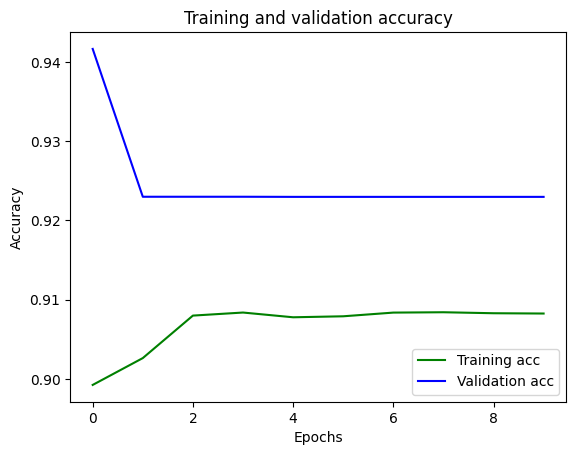

In [126]:
plt.plot( acc, 'b', label='Training acc',color='green')
plt.plot( val_acc, 'b', label='Validation acc',color='blue')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [197]:
test_sentences_exp = [
    "Ali, spor yapmaktan hoşlanır, bu da onun sağlıklı bir yaşam sürmesine yardımcı olur.",
    "Öğrenciler, sınavdan önce ders çalışırlar, bu da başarılarını artırır.",
    "Deniz, kumda yürümeyi sever, bu da ona huzur verir.",
    "Hava güzel, dışarıda piknik yapabiliriz.",
    "Bahar geldiği için ağaçlar çiçek açar.",
    "Çocuklar, parkta oyun oynarlar, bu da sosyal becerilerini geliştirir.",
    "Yağmur yağıyor, evde oturup bir kitap okuyabilirim.",
    "Yemek yapmayı seviyorum, bu da benim yaratıcı tarafımı ortaya çıkarıyor.",
    "Mevsimler değişir, bu da doğanın güzelliklerini fark etmemize neden olur.",
    "Arkadaşım, partiye gitmek istediğini söyledi, bu da beni sevindirdi.",
    "Şehirdeki müzeler, sanatseverler için ilginç yerlerdir.",
    "Çay içmeyi seviyorum, özellikle de soğuk kış günlerinde.",
    "Çocuklar, annelerinin yanında güvende hissederler.",
    "Güneş battı, gökyüzündeki renkler harika.",
    "Öğrenciler, derslerinde başarılı olmak için düzenli çalışmalıdırlar.",
    "Bu kitap ilginç, içinde pek çok bilgi var.",
    "Ayşe, arkadaşının doğum günü partisine gitmek için hazırlıklar yapıyor.",
    "Deniz, kumda yürümekten hoşlanır, bu da ona huzur verir.",
    "Yeni restoranda yemek yedik, yemekler çok lezzetliydi.",
    "Bilgisayarımı güncelledim, bu da performansını artırdı."
]

In [164]:
test_sentences = [] 
test_label = []

for exm in test_sentences_exp:
    new_txt, new_label = preprocessing(exm)
    test_sentences.append(new_txt)
    test_label.append(new_label)

In [165]:
test_sentences

['ali, spor yapmaktan hoslanir, buda onun saglikli bir yasam surmesine yardimci olur.',
 'ogrenciler, sinavdan once ders calisirlar, buda basarilarini artirir.',
 'deniz, kumda yurumeyi sever, buda ona huzur verir.',
 'hava guzel, disarida piknik yapabiliriz.',
 'bahar geldigi icin agaclar cicek acar.',
 'cocuklar, parkta oyun oynarlar, buda sosyal becerilerini gelistirir.',
 'yagmur yagiyor, evde oturup bir kitap okuyabilirim.',
 'yemek yapmayi seviyorum, buda benim yaratici tarafimi ortaya cikariyor.',
 'mevsimler degisir, buda doganin guzelliklerini fark etmemize neden olur.',
 'arkadasim, partiye gitmek istedigini soyledi, buda beni sevindirdi.',
 'sehirdeki muzeler, sanatseverler icin ilginc yerlerdir.',
 'cay icmeyi seviyorum, ozelliklede soguk kis gunlerinde.',
 'cocuklar, annelerinin yaninda guvende hissederler.',
 'gunes batti, gokyuzundeki renkler harika.',
 'ogrenciler, derslerinde basarili olmak icin duzenli calismalidirlar.',
 'bu kitap ilginc, icinde pek cok bilgi var.',


In [166]:
data_test = {
    'text':test_sentences,
    'label':test_label
}
test_data = Dataset.from_dict( {'text': data_test['text'], 'label': data_test['label']})
dataset_test = DatasetDict(
    {
        'test': test_data
    }
)

In [167]:
data_test['text']

['ali, spor yapmaktan hoslanir, buda onun saglikli bir yasam surmesine yardimci olur.',
 'ogrenciler, sinavdan once ders calisirlar, buda basarilarini artirir.',
 'deniz, kumda yurumeyi sever, buda ona huzur verir.',
 'hava guzel, disarida piknik yapabiliriz.',
 'bahar geldigi icin agaclar cicek acar.',
 'cocuklar, parkta oyun oynarlar, buda sosyal becerilerini gelistirir.',
 'yagmur yagiyor, evde oturup bir kitap okuyabilirim.',
 'yemek yapmayi seviyorum, buda benim yaratici tarafimi ortaya cikariyor.',
 'mevsimler degisir, buda doganin guzelliklerini fark etmemize neden olur.',
 'arkadasim, partiye gitmek istedigini soyledi, buda beni sevindirdi.',
 'sehirdeki muzeler, sanatseverler icin ilginc yerlerdir.',
 'cay icmeyi seviyorum, ozelliklede soguk kis gunlerinde.',
 'cocuklar, annelerinin yaninda guvende hissederler.',
 'gunes batti, gokyuzundeki renkler harika.',
 'ogrenciler, derslerinde basarili olmak icin duzenli calismalidirlar.',
 'bu kitap ilginc, icinde pek cok bilgi var.',


In [168]:
tokenized_test = dataset_test.map(preprocess_function, batched=True)
tokenized_test

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 20
    })
})

In [174]:
tf_test = model.prepare_tf_dataset(
    tokenized_test["test"],
    shuffle=False,
    batch_size=1,
    collate_fn=data_collator,
)

In [175]:
results = model.predict(tf_test)

20/20 [==============================] - 1s 23ms/step


In [184]:
pred = np.argmax(results['logits'],axis=-1)

In [192]:
list(pred)

[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]

In [199]:
test_sentences_exp

['Ali, spor yapmaktan hoşlanır, bu da onun sağlıklı bir yaşam sürmesine yardımcı olur.',
 'Öğrenciler, sınavdan önce ders çalışırlar, bu da başarılarını artırır.',
 'Deniz, kumda yürümeyi sever, bu da ona huzur verir.',
 'Hava güzel, dışarıda piknik yapabiliriz.',
 'Bahar geldiği için ağaçlar çiçek açar.',
 'Çocuklar, parkta oyun oynarlar, bu da sosyal becerilerini geliştirir.',
 'Yağmur yağıyor, evde oturup bir kitap okuyabilirim.',
 'Yemek yapmayı seviyorum, bu da benim yaratıcı tarafımı ortaya çıkarıyor.',
 'Mevsimler değişir, bu da doğanın güzelliklerini fark etmemize neden olur.',
 'Arkadaşım, partiye gitmek istediğini söyledi, bu da beni sevindirdi.',
 'Şehirdeki müzeler, sanatseverler için ilginç yerlerdir.',
 'Çay içmeyi seviyorum, özellikle de soğuk kış günlerinde.',
 'Çocuklar, annelerinin yanında güvende hissederler.',
 'Güneş battı, gökyüzündeki renkler harika.',
 'Öğrenciler, derslerinde başarılı olmak için düzenli çalışmalıdırlar.',
 'Bu kitap ilginç, içinde pek çok bilgi

In [207]:
for i,(sentence,label) in enumerate(zip(test_sentences_exp,list(pred))):
    print(f'" {sentence} " is predicted {label}')
    if label == 1:
        print('SEPERATED')
    else:
        print('NON-SEPERATED')
    print("--------------------------------------------------------------------------------")

" Ali, spor yapmaktan hoşlanır, bu da onun sağlıklı bir yaşam sürmesine yardımcı olur. " is predicted 1
SEPERATED
--------------------------------------------------------------------------------
" Öğrenciler, sınavdan önce ders çalışırlar, bu da başarılarını artırır. " is predicted 1
SEPERATED
--------------------------------------------------------------------------------
" Deniz, kumda yürümeyi sever, bu da ona huzur verir. " is predicted 1
SEPERATED
--------------------------------------------------------------------------------
" Hava güzel, dışarıda piknik yapabiliriz. " is predicted 1
SEPERATED
--------------------------------------------------------------------------------
" Bahar geldiği için ağaçlar çiçek açar. " is predicted 0
NON-SEPERATED
--------------------------------------------------------------------------------
" Çocuklar, parkta oyun oynarlar, bu da sosyal becerilerini geliştirir. " is predicted 1
SEPERATED
-----------------------------------------------------------